# Lucene with Modified Queries

**Purpose**: This document serves to understand how our Precision / Recall on Lucene queries would change as a result of query preprocessing.

## Loading our Dataset

In [3]:
import utils
import pickle
import pandas as pd
from tqdm import tqdm_notebook
from joblib import Parallel, delayed
from multiprocessing import cpu_count
import numpy as np
import seaborn as sns

In [4]:
claims, labels, article_list, claim_set, claim_to_article = utils.extract_fever_jsonl_data("../train.jsonl")

Num Distinct Claims 109810
Num Data Points 125051


## Developing a query preprocessor.

In [2]:
import nltk

In [20]:
tokens = nltk.word_tokenize(claims[2])

*Potthast et al* used nouns, verbs, and adjectives only in their queries.

In [25]:
nltk.help.upenn_tagset()


$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

In [87]:
#desired_pos = ["JJ", "JJR", "JJS", "NN", "NN", "NNP", "NNPS", "NNS", "VB", "VBD", "VBG", "VBN", "VBP", "VBZ"]
desired_pos = ["CD", "FW", "JJ", "JJR", "JJS", "NN", "NN", "NNP", "NNPS", "NNS"]

In [88]:
def preprocess_query(q, desired_pos):
    tokens = nltk.word_tokenize(q)
    pos = nltk.pos_tag(tokens)
    final_res = []
    for p in pos:
        if p[1] in desired_pos:
            final_res.append(p[0])
            
    return " ".join(final_res)

In [89]:
preprocess_query(claims[0], desired_pos)

'Nikolaj Coster-Waldau Fox Broadcasting Company'

## Running Precision, Recall

In [53]:
k = [1, 2, 5, 10, 20, 50, 100, 200, 300, 400]

In [54]:
def score_claim(claim):
    cleaned_claim = preprocess_query(claim, desired_pos)
    cleaned_claim = claim.replace("/", " ")
    choices = utils.query_lucene(cleaned_claim, str(max(k)))
    retrieved = utils.process_lucene_output(choices)
    relevant = claim_to_article[claim]
    mAP = {}
    for i in k:
        precision = utils.calculate_precision(retrieved=retrieved, relevant=relevant, k=i)
        recall = utils.calculate_recall(retrieved=retrieved, relevant=relevant, k=i)
        mAP[i] = {}
        mAP[i]['precision'] = precision
        mAP[i]['recall'] = recall
    return mAP

In [90]:
for c in list(claim_to_article.keys())[:10000]:
    print("Claim: {}".format(c))
    print("Cleaned Claim: {}".format(preprocess_query(c, desired_pos)))
    print()

Claim: Artemis is represented by a huntress.
Cleaned Claim: Artemis huntress

Claim: The West Wing consists of the Oval Office.
Cleaned Claim: West Wing Oval Office

Claim: Ludacris's record featured the tone of his previous novels.
Cleaned Claim: Ludacris record tone previous novels

Claim: Tim Rice worked for any company except Walt Disney Studios.
Cleaned Claim: Tim Rice company Walt Disney Studios

Claim: The blue whale's body is somewhat lighter underneath.
Cleaned Claim: blue whale body lighter underneath

Claim: Sunburn was released by Paramount Pictures.
Cleaned Claim: Sunburn Paramount Pictures

Claim: Music Bank (TV series) has been hosted by a South Korean actress born in 1981.
Cleaned Claim: Music Bank TV series South Korean actress 1981

Claim: Jenni Rivera wrote songs.
Cleaned Claim: Jenni Rivera songs

Claim: Bob Dylan is an American recording artist.
Cleaned Claim: Bob Dylan American recording artist

Claim: The Dark Half is a 1983 film.
Cleaned Claim: Dark Half 1983 fi

Cleaned Claim: Martina Hingis citizen Switzerland Czechoslovakia

Claim: Iceland has a tundra climate.
Cleaned Claim: Iceland tundra climate

Claim: Allen Iverson was a poor scorer.
Cleaned Claim: Allen Iverson poor scorer

Claim: Steffi Graf is incapable of being a tennis player.
Cleaned Claim: Steffi Graf incapable tennis player

Claim: The People vs. Larry Flynt is a biographical  drama novel only.
Cleaned Claim: People vs. Larry Flynt biographical drama novel

Claim: Avengers: Age of Ultron is unreleased.
Cleaned Claim: Avengers Age Ultron unreleased

Claim: Logan had the character Wolverine.
Cleaned Claim: Logan character Wolverine

Claim: Hilary Swank played an unnamed recurring background character on Beverly Hills 90210.
Cleaned Claim: Hilary Swank unnamed background character Beverly Hills 90210

Claim: Michelle Obama served as the First Lady of the United States.
Cleaned Claim: Michelle Obama First Lady United States

Claim: In 2010, Midwestern Gothic was founded.
Cleaned Cla

Cleaned Claim: Ulysses S. Grant peaceful resolution Virginius Affair

Claim: The Sopranos is a movie.
Cleaned Claim: Sopranos movie

Claim: Western New York is considered separate from the Great Lakes Region.
Cleaned Claim: Western New York separate Great Lakes Region

Claim: There isn't an official religion in Azerbaijan.
Cleaned Claim: official religion Azerbaijan

Claim: The French Open is also called by the name of a stadium.
Cleaned Claim: French Open name stadium

Claim: Montreal is home to a mountain called Mount Royal.
Cleaned Claim: Montreal mountain Mount Royal

Claim: As the World Turns was replaced by The Talk.
Cleaned Claim: World Turns Talk

Claim: Dean Martin was an entertainment industry worker.
Cleaned Claim: Dean Martin entertainment industry worker

Claim: Carmelo Anthony went to a National Championship with the Orangemen.
Cleaned Claim: Carmelo Anthony National Championship Orangemen

Claim: Patrick Dempsey turned down all offers to work in Transformers movies.
Clea

Cleaned Claim: Somalia informal economy livestock telecommunications income Somalis

Claim: Lymelife is a 2008 beverage.
Cleaned Claim: Lymelife 2008 beverage

Claim: Ethiopia has areas that can be described as jungles.
Cleaned Claim: Ethiopia areas jungles

Claim: Silicon Valley refers to a part of the San Francisco Bay Area.
Cleaned Claim: Silicon Valley refers part San Francisco Bay Area

Claim: Tokyo is in Japan.
Cleaned Claim: Tokyo Japan

Claim: Holiday: A Soldier Is Never Off Duty had a producer.
Cleaned Claim: Holiday Soldier Never Off Duty producer

Claim: Rebecca Hall was in the film Christine.
Cleaned Claim: Rebecca Hall film Christine

Claim: Istanbul is a village.
Cleaned Claim: Istanbul village

Claim: Romelu Lukaku played for the Rolling Stones.
Cleaned Claim: Romelu Lukaku Rolling Stones

Claim: Gianluigi Buffon has won football titles as part of Juventus F.C.
Cleaned Claim: Gianluigi Buffon football titles part Juventus F.C

Claim: While Akbar owned the bank, its wealt

Cleaned Claim: Renaissance upheaval

Claim: Charles Dickens passed away in 1870.
Cleaned Claim: Charles Dickens 1870

Claim: Nina Simone is a Russian czar.
Cleaned Claim: Nina Simone Russian czar

Claim: Ginger Baker was almost inducted into the Classic Drummer Hall of Fame.
Cleaned Claim: Ginger Baker Classic Drummer Hall Fame

Claim: Liverpool F.C. is not in the English football league.
Cleaned Claim: Liverpool F.C English football league

Claim: Louise Simonson is a comic book writer.
Cleaned Claim: Louise Simonson comic book writer

Claim: My Sweet Lord is a song by a former Beatle.
Cleaned Claim: Sweet Lord song former Beatle

Claim: Sweden borders Norway to the west.
Cleaned Claim: Sweden borders Norway west

Claim: Zach Galifianakis starred in The Campaign in 2007.
Cleaned Claim: Zach Galifianakis Campaign 2007

Claim: Jorah Mormont is portrayed solely by a French actor.
Cleaned Claim: Jorah Mormont French actor

Claim: Adam Sandler died in 1966.
Cleaned Claim: Adam Sandler 1966

Claim: Franklin D. Roosevelt spearheaded the New Deal.
Cleaned Claim: Franklin D. Roosevelt New Deal

Claim: John Connally was a Governor of Texas.
Cleaned Claim: John Connally Governor Texas

Claim: Taylor Kitsch worked on the film X-Men Origins: Wolverine.
Cleaned Claim: Taylor Kitsch film X-Men Origins Wolverine

Claim: Singapore is in Asia.
Cleaned Claim: Singapore Asia

Claim: Twitter had about 1.6 billion search queries per day in September of 2012.
Cleaned Claim: Twitter 1.6 billion search queries day September 2012

Claim: Martin Luther King Jr. is not dead.
Cleaned Claim: Martin Luther King Jr. dead

Claim: A Few Good Men features Tom Cruise.
Cleaned Claim: Few Good Men features Tom Cruise

Claim: Hogwarts is the primary setting for the first five books in the Harry Potter series.
Cleaned Claim: Hogwarts primary setting first five books Harry Potter series

Claim: Prometheus is a science-fiction horror film that involves aliens.
Cleaned Claim: Prometheus science-fiction horror

Claim: Lust for Life was modified by Norman Corwin.
Cleaned Claim: Lust Life Norman Corwin

Claim: Without Limits has Donald Sutherland in it.
Cleaned Claim: Limits Donald Sutherland

Claim: West Hollywood, California is in the United States of America.
Cleaned Claim: West Hollywood California United States America

Claim: A fantasy film usually involves something.
Cleaned Claim: fantasy film something

Claim: Amazon.com sells Blu-rays.
Cleaned Claim: Amazon.com Blu-rays

Claim: The main character of Memento abstains from using tattoos to track information he cannot remember.
Cleaned Claim: main character Memento abstains tattoos information

Claim: Dolly Parton is an actress.
Cleaned Claim: Dolly Parton actress

Claim: There is a co-op apartment in NYC called The Dakota.
Cleaned Claim: co-op apartment NYC Dakota

Claim: Cara Delevigne was a Gemini.
Cleaned Claim: Cara Delevigne Gemini

Claim: One-Punch Man is a film series.
Cleaned Claim: One-Punch Man film series

Claim: Furious 7 wa

Cleaned Claim: Youth Olympic Games YOG International Olympic Committee

Claim: Leonard Nimoy directed Three Men and a Baby.
Cleaned Claim: Leonard Nimoy Three Men Baby

Claim: There are silver reserves in Kolyma.
Cleaned Claim: silver reserves Kolyma

Claim: Mike Love was alive in the 1780's.
Cleaned Claim: Mike Love alive 1780

Claim: Bruce Springsteen has children.
Cleaned Claim: Bruce Springsteen children

Claim: Miley Cyrus's fifth album is called Bangerz.
Cleaned Claim: Miley Cyrus fifth album Bangerz

Claim: Susan Sarandon received nominations for A Coupla White Boys Sitting Around Talking.
Cleaned Claim: Susan Sarandon nominations Coupla White Boys Talking

Claim: Bronson (film) is a 2008 American film.
Cleaned Claim: Bronson film 2008 American film

Claim: Daniel Craig is the first-longest serving James Bond.
Cleaned Claim: Daniel Craig first-longest serving James Bond

Claim: The Arabian Peninsula consists of multiple places.
Cleaned Claim: Arabian Peninsula multiple places

C

Cleaned Claim: Tall Story director Bolivia

Claim: Bonnie Hunt narrated Cheaper by the Dozen.
Cleaned Claim: Bonnie Hunt Cheaper Dozen

Claim: In the Heart of the Sea premiered in the 2010s.
Cleaned Claim: Heart Sea 2010s

Claim: Leukemia involves a lack.
Cleaned Claim: Leukemia lack

Claim: Ludacris has not won a Grammy award.
Cleaned Claim: Ludacris Grammy award

Claim: Laura Dern performed in Star Wars.
Cleaned Claim: Laura Dern Star Wars

Claim: Sepsis is more common among men than women.
Cleaned Claim: Sepsis common men women

Claim: John D. Rockefeller was a person in the United States.
Cleaned Claim: John D. Rockefeller person United States

Claim: The Chainsmokers released the book Closer.
Cleaned Claim: Chainsmokers book Closer

Claim: Mexico does not have the most UNESCO World Heritage Sites in the Americas.
Cleaned Claim: Mexico UNESCO World Heritage Americas

Claim: Istanbul is outside of Turkey.
Cleaned Claim: Istanbul Turkey

Claim: Louis Tomlinson was a television actor.

Cleaned Claim: Academy Honorary Award Board Governors Academy Motion Picture Arts Sciences

Claim: Never Go Back's author's name is J. R. R. Tolkien.
Cleaned Claim: Go Back author name J. R. R. Tolkien

Claim: Budapest has the Dohány Street Synagogue in its 7th district.
Cleaned Claim: Budapest Dohány Street Synagogue 7th district

Claim: Romelu Lukaku played for every team except the Anderlecht team.
Cleaned Claim: Romelu Lukaku team Anderlecht team

Claim: Abu Bakr al-Baghdadi has been accused of kidnapping.
Cleaned Claim: Abu Bakr al-Baghdadi kidnapping

Claim: Tetris' designer was Alexey Pajitnov.
Cleaned Claim: Tetris designer Alexey Pajitnov

Claim: Transformers: Age of Extinction grossed money
Cleaned Claim: Transformers Age Extinction money

Claim: The Fifth Element was a financial success, earning more than $263 million.
Cleaned Claim: Fifth Element financial success more 263 million

Claim: Tom Cruise stars in action movies.
Cleaned Claim: Tom Cruise stars action movies

Clai

Cleaned Claim: Batman third film Quentin Tarantino

Claim: Legion stars an animal.
Cleaned Claim: Legion animal

Claim: Psychology aims to comprehend groups and individuals.
Cleaned Claim: Psychology aims groups individuals

Claim: Theodore Roosevelt spoke harshly about President Woodrow Wilson.
Cleaned Claim: Roosevelt President Woodrow Wilson

Claim: David Tennant appeared on television in Britain.
Cleaned Claim: David Tennant television Britain

Claim: Transformers (film) is based on a toy line.
Cleaned Claim: Transformers film toy line

Claim: U2 has released 13 studio albums, all award-winning.
Cleaned Claim: U2 13 studio albums award-winning

Claim: Islam is growing more rapidly than any other major religion.
Cleaned Claim: Islam other major religion

Claim: The album Thriller was released by Michael Jackson.
Cleaned Claim: album Thriller Michael Jackson

Claim: 25 was released through Supreme Records.
Cleaned Claim: 25 Supreme Records

Claim: Demi Lovato has released five single

Cleaned Claim: David Jones video game developer games programmer

Claim: Black Sails is a prequel to the Robert Louis Stevenson novel "Treasure Island".
Cleaned Claim: Black Sails prequel Robert Louis Stevenson Treasure Island

Claim: A British film critic is Robbie Collin.
Cleaned Claim: British film critic Robbie Collin

Claim: American Airlines Flight 77 was involved in the September 11 attacks.
Cleaned Claim: American Airlines Flight 77 September 11 attacks

Claim: Doug Jones has worked with Joss Whedon.
Cleaned Claim: Doug Jones Joss Whedon

Claim: Timon & Pumbaa is only live action.
Cleaned Claim: Timon Pumbaa live action

Claim: Gorillaz play soul music.
Cleaned Claim: Gorillaz play soul music

Claim: Mission: Impossible 6 is produced by James Cameron.
Cleaned Claim: Mission Impossible 6 James Cameron

Claim: Jim Carrey appeared in Kick-Ass 2 in 2012.
Cleaned Claim: Jim Carrey Kick-Ass 2 2012

Claim: Kirk Douglas is a Gemini.
Cleaned Claim: Kirk Douglas Gemini

Claim: Chester Be

Cleaned Claim: Benedict Cumberbatch actor

Claim: Luxo Jr. is a computer-animated film.
Cleaned Claim: Luxo Jr. computer-animated film

Claim: Charles, Prince of Wales was born in the year 1950.
Cleaned Claim: Charles Prince Wales year 1950

Claim: Turkey joined a union.
Cleaned Claim: Turkey union

Claim: Muhammad left Mecca in 652.
Cleaned Claim: Muhammad Mecca 652

Claim: Ruth Negga acts in films.
Cleaned Claim: Ruth Negga films

Claim: Canada is not old.
Cleaned Claim: Canada old

Claim: The Fosters airs on Freeform.
Cleaned Claim: Fosters airs Freeform

Claim: Audrey Horne was introduced in a series.
Cleaned Claim: Audrey Horne series

Claim: Saamy is a film.
Cleaned Claim: Saamy film

Claim: Devdas was screened during a film festival.
Cleaned Claim: Devdas film festival

Claim: Michelle Obama is not married.
Cleaned Claim: Michelle Obama

Claim: Armadillo World Headquarters closed in Miami.
Cleaned Claim: Armadillo World Headquarters Miami

Claim: Alessia Cara is a Canadian singe

Cleaned Claim: Gary Ridgway people 80 90

Claim: MS Dhoni is a cricket player for India.
Cleaned Claim: MS Dhoni cricket player India

Claim: The 21st was the day when Sophie Turner was born.
Cleaned Claim: 21st day Sophie Turner

Claim: Slash was in Guns N' Roses.
Cleaned Claim: Slash Guns N Roses

Claim: Pan Am is a TV series.
Cleaned Claim: Pan Am TV series

Claim: O. J. Simpson was born in the 1940s.
Cleaned Claim: O. J. Simpson 1940s

Claim: Black Sabbath released a debut album of the same name.
Cleaned Claim: Black Sabbath debut album same name

Claim: Kurt Russell signed a contract with Time Warner.
Cleaned Claim: Kurt Russell contract Time Warner

Claim: Willie Nelson was raised by people.
Cleaned Claim: Willie Nelson people

Claim: Krysten Ritter has appeared in a film.
Cleaned Claim: Krysten Ritter film

Claim: Wonder Woman is a person who has Amazonian training.
Cleaned Claim: Wonder Woman person Amazonian training

Claim: Portugal has an advanced economy.
Cleaned Claim: Por

Cleaned Claim: Muhammad Ali name

Claim: Sienna Miller is not British-American.
Cleaned Claim: Sienna Miller British-American

Claim: Gwen Stefani's band released an album in 1995.
Cleaned Claim: Gwen Stefani band album 1995

Claim: Slang is a popular culture category.
Cleaned Claim: Slang popular culture category

Claim: 30 Seconds to Mars is the debut album of the band of the same name.
Cleaned Claim: 30 Seconds Mars debut album band same name

Claim: Pixar uses CGI animation to create films.
Cleaned Claim: Pixar CGI animation films

Claim: Azerbaijan is in the Turkic world.
Cleaned Claim: Azerbaijan Turkic world

Claim: On April 12, 1980, William R. Tolbert Jr. died.
Cleaned Claim: April 12 1980 William R. Tolbert Jr.

Claim: Donald Glover released an album.
Cleaned Claim: Donald Glover album

Claim: Gerald Ford was appointed to the vice presidency under the 25th Amendment.
Cleaned Claim: Gerald Ford vice presidency 25th Amendment

Claim: The Danish Girl is a film.
Cleaned Claim: Da

Cleaned Claim: Carrie Fisher Postcards Edge 2005

Claim: Eddie Redmayne played a part in Like Minds.
Cleaned Claim: Eddie Redmayne part Minds

Claim: Taylor Sheridan was in a television series.
Cleaned Claim: Taylor Sheridan television series

Claim: Game of Thrones has an international fandom.
Cleaned Claim: Game Thrones international fandom

Claim: Fergie has a fragrance called "Outspoken".
Cleaned Claim: Fergie fragrance Outspoken

Claim: Gerard Butler acts.
Cleaned Claim: Gerard Butler

Claim: Kobe Bryant won some NBA championships.
Cleaned Claim: Kobe Bryant NBA championships

Claim: Tender Mercies is an Japanese drama.
Cleaned Claim: Tender Mercies Japanese drama

Claim: Rob Lowe was in the cast of Parks and Recreations.
Cleaned Claim: Rob Lowe cast Parks Recreations

Claim: The 2000 Football League Cup Final was played at the end of March.
Cleaned Claim: 2000 Football League Cup Final end March

Claim: Reg Watson has created shows.
Cleaned Claim: Reg Watson shows

Claim: Serena 

Claim: Nikita is a TV series.
Cleaned Claim: Nikita TV series

Claim: John Woo had a television series published by Virgin Comics.
Cleaned Claim: John Woo television series Virgin Comics

Claim: Chris Hardwick was born on Thursday November 23, 1971.
Cleaned Claim: Chris Hardwick Thursday November 23 1971

Claim: Lily James did not begin her professional acting career in 2010.
Cleaned Claim: James professional acting career 2010

Claim: The Beastie Boys' fifth studio album was not Hello Nasty.
Cleaned Claim: Beastie Boys fifth studio album Hello Nasty

Claim: Simon Callow was included in James and the Giant Peach.
Cleaned Claim: Simon Callow James Giant Peach

Claim: United States Congress has 435 Representatives.
Cleaned Claim: United States Congress 435 Representatives

Claim: System of a Down has sold records.
Cleaned Claim: System Down records

Claim: Mark Bomback is from New Rochelle, New York.
Cleaned Claim: Mark Bomback New Rochelle New York

Claim: Ron Perlman has a full name.
C

Cleaned Claim: Abu Bakr al-Baghdadi crime

Claim: The Voice involves contestants competing for a prize.
Cleaned Claim: Voice contestants prize

Claim: Maynard James Keenan is an investor in Cobras & Matadors.
Cleaned Claim: Maynard James Keenan investor Cobras Matadors

Claim: King Kong was directed by a person.
Cleaned Claim: Kong person

Claim: Alan Tudyk is in the web series Con Man (web series).
Cleaned Claim: Alan Tudyk web series Con Man web series

Claim: Zach Galifianakis was featured in The Campaign.
Cleaned Claim: Zach Galifianakis Campaign

Claim: The Wachowskis directed a movie.
Cleaned Claim: Wachowskis movie

Claim: The Olympic Games are sporting events that are international.
Cleaned Claim: Olympic Games events international

Claim: Leukemia led to 353,500 deaths in 2015.
Cleaned Claim: Leukemia 353,500 deaths 2015

Claim: Taylor Schilling made her film debut in 1807.
Cleaned Claim: Taylor film debut 1807

Claim: At least one right was acquired by Hisense in 2015.
Cleane

Cleaned Claim: Denis Leary tire iron

Claim: Jared Padalecki was in Buffy the Vampire Slayer.
Cleaned Claim: Jared Padalecki Buffy Vampire Slayer

Claim: Miley Cyrus's fifth album is called Miley Cyrus & Her Dead Petz.
Cleaned Claim: Miley Cyrus fifth album Miley Cyrus Her Dead Petz

Claim: Lisa Bonet died in 1966.
Cleaned Claim: Lisa Bonet 1966

Claim: Mariah Carey topped a chart.
Cleaned Claim: Mariah Carey chart

Claim: Hisense acquired the right to sell dogs in the Americas.
Cleaned Claim: Hisense right dogs Americas

Claim: Deadpool (film) was directed by an American film director and visual effects artist.
Cleaned Claim: Deadpool film American film director visual effects artist

Claim: Santorini is located southeast of mainland Greece.
Cleaned Claim: Santorini southeast mainland Greece

Claim: Holly Hunter has won an Emmy for Roe v. Wade.
Cleaned Claim: Hunter Emmy Roe v. Wade

Claim: Paris is in Europe.
Cleaned Claim: Paris Europe

Claim: Tiger Woods won 14 professional major g

Cleaned Claim: Aruba eleven regions census purposes

Claim: Emma Stone was started acting in her adulthood.
Cleaned Claim: Emma Stone adulthood

Claim: The Divergent Series: Allegiant is not based on the novel of the same name.
Cleaned Claim: Divergent Series Allegiant novel same name

Claim: Kate Nash is a writer.
Cleaned Claim: Kate Nash writer

Claim: The Twilight Saga stars someone.
Cleaned Claim: Twilight Saga someone

Claim: My Sweet Lord was written in praise of the Hindu god Krishna.
Cleaned Claim: Sweet Lord praise Hindu god Krishna

Claim: In 1982, Michael Jackson released an album.
Cleaned Claim: 1982 Michael Jackson album

Claim: Tramadol may cause a sensation that causes the desire or reflex to scratch
Cleaned Claim: Tramadol sensation desire reflex

Claim: There Will Be Blood is a movie.
Cleaned Claim: Blood movie

Claim: Carmelo Anthony led the Orangemen to ruin.
Cleaned Claim: Carmelo Anthony Orangemen

Claim: The G1 Climax is held by the WWE.
Cleaned Claim: G1 Climax W

Cleaned Claim: Logan Paris

Claim: Malcolm Young is retired.
Cleaned Claim: Malcolm Young

Claim: It's Always Sunny in Philadelphia is a television black comedy.
Cleaned Claim: Always Sunny Philadelphia television black comedy

Claim: Baahubali 2: The Conclusion is a 2017 Indian film.
Cleaned Claim: 2 Conclusion 2017 Indian film

Claim: Sherlock is a TV series.
Cleaned Claim: Sherlock TV series

Claim: The Wolf of Wall Street (2013 film) was a film released in 2013.
Cleaned Claim: Wolf Wall Street 2013 film film 2013

Claim: Chris Hardwick hosted a show.
Cleaned Claim: Chris Hardwick show

Claim: Dan Martin rides for the ProTeam for UCI.
Cleaned Claim: Dan Martin ProTeam UCI

Claim: Jeff Goldblum starred in Independence Day: Resurgence.
Cleaned Claim: Jeff Goldblum Independence Day Resurgence

Claim: Cells are what zero organisms are composed of.
Cleaned Claim: Cells zero organisms

Claim: The Simpsons series will be renewed for a another season.
Cleaned Claim: Simpsons series season



Cleaned Claim: Bad cast Giancarlo Esposito

Claim: Kumail Nanjiani and Emily V. Gordon have always been single.
Cleaned Claim: Kumail Nanjiani Emily V. Gordon single

Claim: Lisa Marie Presley is a singer.
Cleaned Claim: Lisa Marie Presley singer

Claim: Frank Ocean was denied American citizenship.
Cleaned Claim: Frank Ocean American citizenship

Claim: Heidi Klum had the lead role in Ella Enchanted.
Cleaned Claim: Heidi Klum lead role Ella Enchanted

Claim: Lewis Hamilton is a non-competitive amateur racer.
Cleaned Claim: Lewis Hamilton non-competitive amateur racer

Claim: Laura Linney worked on 42nd Street.
Cleaned Claim: Laura Linney 42nd Street

Claim: The United States Environmental Protection Agency began operation before Nixon signed any executive order.
Cleaned Claim: United States Environmental Protection Agency operation Nixon executive order

Claim: Hulk is a TV show.
Cleaned Claim: Hulk TV show

Claim: The Philippines was named by a Chinese explorer.
Cleaned Claim: Philipp

Cleaned Claim: Hugh Jackman Academy Award Best Actor

Claim: Jeff Hardy is a world champion.
Cleaned Claim: Jeff Hardy world champion

Claim: Mr. Sunshine began its run on May 9.
Cleaned Claim: Mr. Sunshine run May 9

Claim: Mystique is the foster mother of Rogue.
Cleaned Claim: Mystique foster mother Rogue

Claim: Economic development is included in International Relations.
Cleaned Claim: Economic development International Relations

Claim: Cosmetics exclude cologne.
Cleaned Claim: Cosmetics cologne

Claim: Neil Patrick Harris only began appearing in TV as an adult.
Cleaned Claim: Neil Patrick Harris TV adult

Claim: Venice is located in northern France.
Cleaned Claim: Venice northern France

Claim: Lemon Sky presented in 1970.
Cleaned Claim: Lemon Sky 1970

Claim: Hitman is a comedy.
Cleaned Claim: Hitman comedy

Claim: Sofía Vergara is a Colombian-American actress.
Cleaned Claim: Sofía Vergara Colombian-American actress

Claim: The Hobbit films starred American Lee Pace.
Cleaned Cla

Cleaned Claim: Tatiana Maslany actress

Claim: Kate Nash made an album.
Cleaned Claim: Kate Nash album

Claim: Pirates of the Caribbean: Dead Men Tell No Tales was delayed thrice.
Cleaned Claim: Pirates Caribbean Dead Men Tell No Tales thrice

Claim: British Fantasy Award categories include two novel categories.
Cleaned Claim: British Fantasy Award categories two novel categories

Claim: Taylor Sheridan is in a television show.
Cleaned Claim: Taylor Sheridan television show

Claim: Jordan Spence has played for six football clubs including Scunthorpe United and Bristol City.
Cleaned Claim: Jordan Spence six football clubs Scunthorpe United Bristol City

Claim: Prince had a home in Chanhassen, Minnesota.
Cleaned Claim: Prince home Chanhassen Minnesota

Claim: Joey Graceffa worked with a website.
Cleaned Claim: Joey Graceffa website

Claim: Ludacris has not won an MTV award.
Cleaned Claim: Ludacris MTV award

Claim: Paul Pogba has won four nonconsecutive Serie A titles.
Cleaned Claim: Pau

Cleaned Claim: Interpersonal psychotherapy centers interpersonal issues

Claim: The last episode of Inhumans released in 1999.
Cleaned Claim: last episode Inhumans 1999

Claim: Transformers: Age of Extinction stars an American rapper as one of the lead roles.
Cleaned Claim: Transformers Age Extinction American rapper one lead roles

Claim: Alfred Hitchcock directed more than fifty films.
Cleaned Claim: Alfred Hitchcock more fifty films

Claim: Gift of the Night Fury stars the voice of a comedian.
Cleaned Claim: Gift Night Fury voice comedian

Claim: Slovenia did not enter NATO and the European Union in 2004.
Cleaned Claim: Slovenia NATO European Union 2004

Claim: Los Angeles is a city in Southern California.
Cleaned Claim: Los Angeles city Southern California

Claim: Austria refused to sign the Austrian State Treaty.
Cleaned Claim: Austria Austrian State Treaty

Claim: American Horror Story: Hotel's premiere date was on October 7, 2015.
Cleaned Claim: American Horror Story Hotel premi

Claim: The President of Russia can convene and adjourn the Federal Assembly.
Cleaned Claim: President Russia Federal Assembly

Claim: Prince released a platinum-selling album in 2004.
Cleaned Claim: Prince platinum-selling album 2004

Claim: Egypt is a country in Africa.
Cleaned Claim: Egypt country Africa

Claim: Mother Teresa received distinctions.
Cleaned Claim: Mother Teresa distinctions

Claim: Grace Kelly starred in American films.
Cleaned Claim: Grace Kelly American films

Claim: Liv Tyler is incapable of being an actress.
Cleaned Claim: Liv Tyler incapable actress

Claim: Nice & Slow was released in 1898.
Cleaned Claim: Nice Slow 1898

Claim: Man of Steel is not a 2013 superhero film.
Cleaned Claim: Man Steel 2013 superhero film

Claim: Veronica Mars is portrayed by an actress.
Cleaned Claim: Veronica Mars actress

Claim: Jon Huntsman Jr. was born on March 26, 1960.
Cleaned Claim: Jon Huntsman Jr. March 26 1960

Claim: Gwen Stefani was not inspired by pop music from the 1980's.

Cleaned Claim: band Blink-182

Claim: Jim Crow laws were enacted by politicians.
Cleaned Claim: Jim Crow laws politicians

Claim: Inhumans's main character is a mutant.
Cleaned Claim: Inhumans main character mutant

Claim: Buddy Holly always refused to perform in Lubbock.
Cleaned Claim: Buddy Holly Lubbock

Claim: Kathy Bates won a Golden Globe Award.
Cleaned Claim: Kathy Bates Golden Globe Award

Claim: British Fantasy Award has a few categories including Best Anthology.
Cleaned Claim: British Fantasy Award few categories Best Anthology

Claim: Nina Simone was enrolled in a conservatory.
Cleaned Claim: Nina Simone conservatory

Claim: Dallol, Ethiopia has an elevation of about 130 m under sea level.
Cleaned Claim: Dallol Ethiopia elevation 130 m sea level

Claim: Harmanpreet Kaur played cricket.
Cleaned Claim: Harmanpreet Kaur cricket

Claim: On Stranger Tides is a fantasy podcast.
Cleaned Claim: Stranger Tides fantasy podcast

Claim: Calvin Harris also goes by another name.
Cleaned C


Claim: Jeanine Pirro was not involved in cases about crimes against the elderly.
Cleaned Claim: Jeanine Pirro cases crimes elderly

Claim: To Kill a Mockingbird was written by an American novelist.
Cleaned Claim: Mockingbird American novelist

Claim: The Divergent Series: Allegiant is based on the political party of the same name.
Cleaned Claim: Divergent Series Allegiant political party same name

Claim: Mark Ruffalo is uninterested in social activism.
Cleaned Claim: Mark Ruffalo social activism

Claim: Doctor Zhivago is a script.
Cleaned Claim: Doctor Zhivago script

Claim: Dileep worked as a producer.
Cleaned Claim: Dileep producer

Claim: Dominick Dunne was a journalist.
Cleaned Claim: Dominick Dunne journalist

Claim: Got a Girl is a band.
Cleaned Claim: Got Girl band

Claim: Elizabeth Taylor has been in Giant.
Cleaned Claim: Elizabeth Taylor Giant

Claim: Hockey has a popularity in Sweden.
Cleaned Claim: Hockey popularity Sweden

Claim: Gujarat is completely landlocked.
Cleaned 

Cleaned Claim: John Kiffmeyer Buck Nasty

Claim: 2011 is the date of creation of Horrible Bosses.
Cleaned Claim: 2011 date creation Horrible Bosses

Claim: Green Day is not a band.
Cleaned Claim: Green Day band

Claim: Alexander Hamilton avoided a college that is now called Columbia University.
Cleaned Claim: Alexander Hamilton college Columbia University

Claim: The science fiction author Isaac Asimov wrote the alternative history novel The Man in the High Castle.
Cleaned Claim: science fiction author Isaac Asimov alternative history Man High Castle

Claim: Brad Pitt appeared as a cowboy in Thelma & Louise.
Cleaned Claim: Brad Pitt cowboy Thelma Louise

Claim: The World Science Festival is headquartered in the United States.
Cleaned Claim: World Science Festival United States

Claim: Between July 29 to August 20 the 2011 FIFA U-20 World Cup took place.
Cleaned Claim: Between July 29 August 20 2011 FIFA U-20 World Cup place

Claim: Snoop Dogg signed with an American record label called

Cleaned Claim: Jack Nicholson Kennedy Center Honor

Claim: Minions is the thirteenth highest-grossing film of all time and the second highest-grossing animated film.
Cleaned Claim: Minions thirteenth highest-grossing film time second highest-grossing film

Claim: Gopalkrishna Gandhi has no experience in politics.
Cleaned Claim: Gopalkrishna Gandhi experience politics

Claim: Cerebral palsy has been documented throughout history.
Cleaned Claim: Cerebral palsy history

Claim: A mixtape is a home-made compilation of music.
Cleaned Claim: mixtape home-made compilation music

Claim: A subclass of anti-nuclear antibodies are are anti-sp100 antibodies.
Cleaned Claim: subclass anti-nuclear antibodies anti-sp100 antibodies

Claim: Geraldine Chaplin has a home in America.
Cleaned Claim: Geraldine Chaplin home America

Claim: Mr. Nobody was made in the 21st century.
Cleaned Claim: Mr. Nobody 21st century

Claim: Donald Glover is an American rapper.
Cleaned Claim: Donald Glover American rapper

Cl

Claim: Jack Black is an American singer that was involved with Kung Fu Panda 3.
Cleaned Claim: Jack Black American singer Kung Fu Panda 3

Claim: The Illusionist was a success critically.
Cleaned Claim: Illusionist success

Claim: Berlin is an animal.
Cleaned Claim: Berlin animal

Claim: Jackie Chan is an operatically trained vocalist and actor.
Cleaned Claim: Jackie Chan trained vocalist actor

Claim: Hugh Jackman has yet to host the Oscars.
Cleaned Claim: Hugh Jackman Oscars

Claim: Socrates was from Athens.
Cleaned Claim: Socrates Athens

Claim: What a Girl Wants is a single by Christina Aguilera.
Cleaned Claim: Girl Wants single Christina Aguilera

Claim: Chris Hemsworth is known for portraying Kim Hyde.
Cleaned Claim: Chris Hemsworth Kim Hyde

Claim: Seth MacFarlane was unrelated to the creation of any American adult animated sitcoms.
Cleaned Claim: Seth MacFarlane unrelated creation American adult sitcoms

Claim: Uranus's interior is composed mostly of rock.
Cleaned Claim: Uranus

Cleaned Claim: Tom Felton Borrowers member

Claim: International Asteroid day is another name of Asteroid Day.
Cleaned Claim: International Asteroid day name Asteroid Day

Claim: The Los Angeles Lakers hold an NBA record.
Cleaned Claim: Los Angeles Lakers NBA record

Claim: Carmelo Anthony plays for a New York team.
Cleaned Claim: Carmelo Anthony New York team

Claim: Wrath of the Titans grossed over a million dollars.
Cleaned Claim: Wrath Titans million dollars

Claim: Trolls (soundtrack) is the soundtrack to the film Trolls.
Cleaned Claim: Trolls soundtrack soundtrack film Trolls

Claim: Law is something that Kamala Harris practices.
Cleaned Claim: Law something Kamala Harris practices

Claim: Seville is located in Europe.
Cleaned Claim: Seville Europe

Claim: The Bends was released by the US's Capitol Records.
Cleaned Claim: Bends US Capitol Records

Claim: The Supremes were a premier act.
Cleaned Claim: Supremes premier act

Claim: Warren Casey is an American writer.
Cleaned Claim:

Cleaned Claim: Octavia Spencer film Zootopia 2016

Claim: Richard Ramirez terrorized the residents of the San Francisco area.
Cleaned Claim: Richard Ramirez residents San Francisco area

Claim: Jack Paar worked as an author.
Cleaned Claim: Jack Paar author

Claim: RuPaul created Born Naked.
Cleaned Claim: RuPaul Born Naked

Claim: Hilda Ellis Davidson wrote about European paganism.
Cleaned Claim: Hilda Ellis Davidson European paganism

Claim: Nicki Minaj has an Award.
Cleaned Claim: Nicki Minaj Award

Claim: 2006 was the year when The principal photography of Vantage Point (film) began.
Cleaned Claim: 2006 year principal photography Vantage Point film

Claim: Egypt is a city.
Cleaned Claim: Egypt city

Claim: Brokeback Mountain is a 2005 drama film.
Cleaned Claim: Brokeback Mountain 2005 drama film

Claim: Jousting was changed into a specialized sport during the Late Middle Ages.
Cleaned Claim: specialized sport Late Middle Ages

Claim: Jessica Chastain made her Broadway debut in 1987.

Cleaned Claim: Connaught Tunnel length 5.022 miles

Claim: Harry Potter is based on the Harry Potter novels written by J. K. Rowling.
Cleaned Claim: Harry Potter Harry Potter novels J. K. Rowling

Claim: Al Capone showed signs of Parkinson's disease.
Cleaned Claim: Al Capone signs Parkinson disease

Claim: Leonardo da Vinci was in Milan for some time.
Cleaned Claim: Leonardo da Vinci Milan time

Claim: Kong: Skull Island is a movie.
Cleaned Claim: Kong Skull Island movie

Claim: A Tony Award was given to Catherine Zeta-Jones.
Cleaned Claim: Tony Award Catherine Zeta-Jones

Claim: The Netherlands capital is Amsterdam.
Cleaned Claim: Netherlands capital Amsterdam

Claim: Meek Mill's debut album is not called Dreams and Nightmares.
Cleaned Claim: Meek Mill debut album Dreams Nightmares

Claim: Neve Campbell stayed in America her whole life.
Cleaned Claim: Neve Campbell America whole life

Claim: Roger Federer plays sports.
Cleaned Claim: Roger Federer sports

Claim: Floyd Mayweather Jr. i

Cleaned Claim: LGBT rights Lady Gaga

Claim: System of a Down briefly broke up in August.
Cleaned Claim: System Down briefly August

Claim: Malaysia is a nation.
Cleaned Claim: Malaysia nation

Claim: David Simon was born in 1980.
Cleaned Claim: David Simon 1980

Claim: Bradley Cooper failed to ever be nominated for an Academy Award.
Cleaned Claim: Bradley Cooper Academy Award

Claim: Zootopia was produced by Byron Howard.
Cleaned Claim: Zootopia Byron Howard

Claim: Elizabeth Banks and David Wain have avoided working together entirely.
Cleaned Claim: Elizabeth Banks David Wain

Claim: John Mayer's third studio album was passed over by organizations that give awards.
Cleaned Claim: John Mayer third studio album organizations awards

Claim: Lincoln Motor Company was founded in the early 1900s.
Cleaned Claim: Lincoln Motor Company early 1900s

Claim: Susan Sarandon only received Emmy nominations.
Cleaned Claim: Susan Sarandon Emmy nominations

Claim: Daz Dillinger is from Wisconsin.
Clea

Cleaned Claim: Stand-up comedy comic style

Claim: Beyond Westworld was a work.
Cleaned Claim: Beyond Westworld work

Claim: Same-sex marriage is legal in Norway.
Cleaned Claim: Same-sex marriage legal Norway

Claim: The Republic of Zambia is bordered to the east by Malawi.
Cleaned Claim: Republic Zambia east Malawi

Claim: Liberia never declared its independence.
Cleaned Claim: Liberia independence

Claim: Oliver Reed was Chinese.
Cleaned Claim: Oliver Reed Chinese

Claim: Egypt is a country.
Cleaned Claim: Egypt country

Claim: Little Boy was a bomb.
Cleaned Claim: Little Boy bomb

Claim: The Apple Store originally opened in 2001.
Cleaned Claim: Apple Store 2001

Claim: King Kong was not co-written by Peter Jackson.
Cleaned Claim: Kong co-written Peter Jackson

Claim: Cosmopolitan as of 2011 contains content which includes articles on political dialogue.
Cleaned Claim: Cosmopolitan 2011 contains content articles political dialogue

Claim: Robert Browning was a foremost Victorian poet

Claim: Tina Turner made a song for a James Bond film.
Cleaned Claim: Tina Turner song James Bond film

Claim: 21 Jump Street was released by Metro-Goldwyn-Mayer.
Cleaned Claim: 21 Jump Street Metro-Goldwyn-Mayer

Claim: The President of Russia is unable to grant pardons.
Cleaned Claim: President Russia unable pardons

Claim: Got a Girl was formed in 2012.
Cleaned Claim: Got Girl 2012

Claim: The Eagles' guitarist is Joe Walsh.
Cleaned Claim: Eagles guitarist Joe Walsh

Claim: Glen Campbell is a rock musician.
Cleaned Claim: Glen Campbell rock musician

Claim: Kris Wu was born in 1990.
Cleaned Claim: Kris Wu 1990

Claim: Sharon Stone played the protagonist Catherine Tramell.
Cleaned Claim: Sharon Stone protagonist Catherine Tramell

Claim: John F. Kennedy ran in the 1960 presidential election.
Cleaned Claim: John F. Kennedy 1960 presidential election

Claim: Paleogene starts from the end of the Cretaceous Period million years ago.
Cleaned Claim: Paleogene end Cretaceous Period million y

Cleaned Claim: Citadelle Laferrière 17 miles city Cap-Haïtien country Georgia

Claim: The United Nations did not win the Nobel Peace Prize.
Cleaned Claim: United Nations Nobel Peace Prize

Claim: In 2015 Kangana Ranaut was able to be seen in a film originating from the Hindi cinema industry.
Cleaned Claim: 2015 Kangana Ranaut able film Hindi cinema industry

Claim: In 1982, Sally Field performed in Kiss Me Goodbye
Cleaned Claim: 1982 Sally Field Kiss Me Goodbye

Claim: Rey Mysterio was a professional wrestler.
Cleaned Claim: Rey Mysterio professional wrestler

Claim: Fahrenheit 451 was released in 1966.
Cleaned Claim: Fahrenheit 451 1966

Claim: Luxembourg is an indirect democracy with a parliamentary monarchy.
Cleaned Claim: Luxembourg indirect democracy parliamentary monarchy

Claim: Antarctica is not the fifth-largest continent.
Cleaned Claim: Antarctica fifth-largest continent

Claim: The height of the One World Trade Center is 1776 feet tall.
Cleaned Claim: height One World Trade 

Cleaned Claim: two years John Mayer hiatus

Claim: The Wolfman's screenplay was written by an American BAFTA-nominated father.
Cleaned Claim: Wolfman screenplay American BAFTA-nominated father

Claim: Dileep was one of the founders of a company that made movies.
Cleaned Claim: Dileep one founders company movies

Claim: Travis Barker was in a band that split up.
Cleaned Claim: Travis Barker band

Claim: Labor Day is incapable of honoring the contributions that workers have made to the prosperity of the country.
Cleaned Claim: Labor Day incapable contributions workers prosperity country

Claim: Francois de Belleforest translated the works of Saint Cyprian into anything except French.
Cleaned Claim: Francois de Belleforest works Saint Cyprian anything French

Claim: Harry Potter is a series of novels by an author.
Cleaned Claim: Harry Potter series novels author

Claim: Paradise is an EP by Lana Del Rey.
Cleaned Claim: Paradise EP Lana Del Rey

Claim: Idris Elba was in Prometheus.
Cleaned

Cleaned Claim: Woody Allen winner four Academy Awards

Claim: Overwatch was unveiled in 2014.
Cleaned Claim: Overwatch 2014

Claim: Richard Eyre directs films.
Cleaned Claim: Richard Eyre films

Claim: Hansel and Gretel falls in the fairy tale category.
Cleaned Claim: Hansel Gretel fairy tale category

Claim: Jerry Goldsmith was nominated for Academy Awards.
Cleaned Claim: Jerry Goldsmith Academy Awards

Claim: Legion is an American horror film from 2010.
Cleaned Claim: Legion American horror film 2010

Claim: Life After Death is by The Notorious B.I.G.
Cleaned Claim: Life Death Notorious B.I.G

Claim: Warren Ellis wrote the film Iron Man 3 is based on.
Cleaned Claim: Warren Ellis film Iron Man 3

Claim: Sepsis is common among males.
Cleaned Claim: Sepsis common males

Claim: The Golden State Warriors were known as the San Francisco Warriors in 1962 when the franchise relocated to the San Francisco Bay Area.
Cleaned Claim: Golden State Warriors San Francisco Warriors 1962 franchise San

Cleaned Claim: Aaliyah second album One Million

Claim: George Clooney does philanthropic work.
Cleaned Claim: George Clooney work

Claim: Barbara Stanwyck acted in Stella Dallas.
Cleaned Claim: Barbara Stanwyck Stella Dallas

Claim: American Pie was written by a man.
Cleaned Claim: American Pie man

Claim: Eminem was a member of a hip hop group from Detroit.
Cleaned Claim: Eminem member hip hop group Detroit

Claim: Kendrick Lamar never performed under the name K-Dot.
Cleaned Claim: Kendrick Lamar name K-Dot

Claim: Paul Wesley refused to appear in Wolf Lake.
Cleaned Claim: Paul Wesley Wolf Lake

Claim: Miss Peregrine's Home for Peculiar Children is an American restaurant.
Cleaned Claim: Miss Peregrine Home Peculiar Children American restaurant

Claim: The Hobbit was not directed by Peter Jackson.
Cleaned Claim: Hobbit Peter Jackson

Claim: Jennifer Aniston was not born in 1969.
Cleaned Claim: Jennifer Aniston 1969

Claim: Odin was known in Old English mythology as Wōden.
Cleaned Clai

Cleaned Claim: Way piece music

Claim: Emma Roberts is a Gemini.
Cleaned Claim: Emma Roberts Gemini

Claim: Katrina Kaif was in a 2012 Indian action spy thriller.
Cleaned Claim: Katrina Kaif 2012 Indian action spy thriller

Claim: Jane Fonda starred in Klute.
Cleaned Claim: Jane Fonda Klute

Claim: Duane Hopwood includes an actor.
Cleaned Claim: Duane Hopwood actor

Claim: Jack Reacher (film) is an American film.
Cleaned Claim: Jack Reacher film American film

Claim: The Strangers starred someone born in September.
Cleaned Claim: Strangers someone September

Claim: Brian Eno joined a rap group.
Cleaned Claim: Brian Eno rap group

Claim: Doug Ducey is the governor of Arizona as of 2017.
Cleaned Claim: Doug Ducey governor Arizona 2017

Claim: Iran has maritime borders with Qatar.
Cleaned Claim: Iran borders Qatar

Claim: Depression was a struggle for Florence Ballard.
Cleaned Claim: Depression struggle Florence Ballard

Claim: Nick Jonas is a songwriter.
Cleaned Claim: Nick Jonas songwri

In [57]:
%load_ext line_profiler

In [59]:
%lprun -f preprocess_query score_claim(claims[0])

In [55]:
loadCached = False

In [ ]:
if not loadCached:
    result = Parallel(n_jobs=8, verbose=1)(delayed(score_claim)(c) for c in list(claim_to_article.keys())[:10000])
    with open("result_pos_two.pkl", "wb") as f:
        pickle.dump(result, f)
else:
    with open("result_pos_two.pkl", "rb") as f:
        result = pickle.load(f)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    7.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   28.8s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  3.0min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  4.3min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:  5.9min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:  7.7min
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed:  9.7min
[Parallel(n_jobs=8)]: Done 4984 tasks      | elapsed: 12.0min
[Parallel(n_jobs=8)]: Done 6034 tasks      | elapsed: 14.5min
[Parallel(n_jobs=8)]: Done 7184 tasks      | elapsed: 17.2min


In [93]:
def calculatemAP(mAP, k):
    mAP_final = {}
    
    for i in k:
        mAP_final[i] = {}
        mAP_final[i]['precision'] = []
        mAP_final[i]['recall'] = []
        
    for ap in mAP:
        for k, v in ap.items():
            mAP_final[k]['precision'].append(v['precision'])
            mAP_final[k]['recall'].append(v['recall'])
    
    return mAP_final

def displaymAP(mAP):
    for k in sorted(mAP.keys()):
        for k_i, v_i in mAP[k].items():
            print("{} @ {}: {}".format(k_i, k, np.mean(v_i)))
        print()
            
def calculate_precision_recall(mAP):
    precision = np.zeros((len(mAP), 2))
    recall = np.zeros((len(mAP), 2))
    for idx, k in enumerate(mAP.keys()):
        precision[idx, 0] = k
        precision[idx, 1] = np.mean(mAP[k]['precision'])
        
        recall[idx, 0] = k
        recall[idx, 1] = np.mean(mAP[k]['recall'])
        
    return precision, recall

In [94]:
mAP = calculatemAP(result, k)

## Understanding our Precision, Recall

How many documents are we dealing with?

In [95]:
!ls ../wiki-pages/processed_pages/ | wc -l

5415460


In [96]:
precision, recall = calculate_precision_recall(mAP)

How is our accuracy on our documents?

In [97]:
data = pd.DataFrame(data=np.vstack([precision[:,1], recall[:,1]]).T, index=precision[:,0], columns=["Precision", "Recall"]).sort_index()

In [98]:
data

,Precision,Recall
1.0,0.000538,0.199095
2.0,0.000787,0.291135
5.0,0.001132,0.415716
10.0,0.001391,0.509304
20.0,0.001643,0.599610
50.0,0.001983,0.721309
100.0,0.002205,0.799451
200.0,0.002371,0.857182
300.0,0.002452,0.884384
400.0,0.002494,0.897708


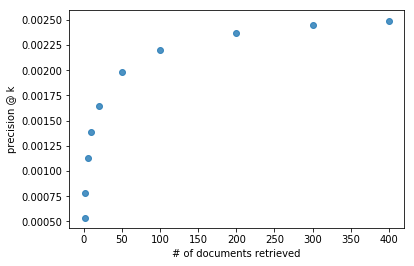

In [99]:
ax = sns.regplot(precision[:,0], precision[:,1], fit_reg=False)
ax.set(xlabel="# of documents retrieved", ylabel="precision @ k")
ax

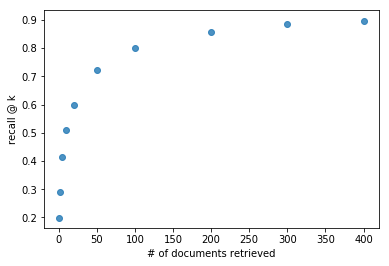

In [100]:
ax = sns.regplot(recall[:,0], recall[:,1], fit_reg=False)
ax.set(xlabel="# of documents retrieved", ylabel="recall @ k")
ax

## Evaluating results

In this section, we just look at a few of the relevant / retrieved results in order to better understand the lookup.

In [101]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [102]:
for claim in list(claim_to_article.keys())[:3]:
    cleaned_claim = claim.replace("/", " ")
    choices = utils.query_lucene(cleaned_claim, "10")
    retrieved = utils.process_lucene_output(choices)
    relevant = claim_to_article[claim]
    printmd("Claim: **{}**".format(claim))
    print("Retrieved {} documents.".format(len(retrieved)))
    print()
    
    print("Relevant Documents:")
    for r in relevant:
        print(r)
    print()
    
    print("Retrieved Documents:")
    for r in retrieved:
        if r in relevant:
            printmd("*{}*".format(r))
        else:
            print(r)
    print()

Claim: **Artemis is represented by a huntress.**

Retrieved 10 documents.

Relevant Documents:
artemis

Retrieved Documents:
bendis


*artemis*

huntress
caryatis
nymphai hyperboreioi
huntress  comics 
temple of artemis  disambiguation 
agrotera
huntress  ship 
artemis fowl



Claim: **The West Wing consists of the Oval Office.**

Retrieved 10 documents.

Relevant Documents:
west wing

Retrieved Documents:
oval office study
roosevelt room


*west wing*

oval office
oval office operations
white house rose garden
list of oval office desks
nathan c  wyeth
west virginia wing civil air patrol
kitson woolen mill



Claim: **Ludacris's record featured the tone of his previous novels.**

Retrieved 10 documents.

Relevant Documents:
ludacris

Retrieved Documents:


*ludacris*

disturbing tha peace  album 
chicken n beer
stand up  ludacris song 
splash waterfalls
georgia  field mob and ludacris song 
what s your fantasy
desmond  novel 
incognegro
ride  ciara song 

